# Imports

In [59]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from scipy import stats

# import warnings
# warnings.filterwarnings('error')

from multihist import Hist1d, Histdd

# Default settings

In [186]:
# Digitizer sample size
dt = 2

# Waveform time labels
spe_ts = np.linspace(0, 639*2, 640) - 340 * 2
# Valid time (because the waveform does not range the full time span)
valid_t_range = (-100, 300)
t_mask = (valid_t_range[0] <= spe_ts) & (spe_ts < valid_t_range[1])
spe_ts = spe_ts[t_mask]
spe_t_edges = np.concatenate([[spe_ts[0] - dt/2], spe_ts + dt/2])


default_params = dict(
    t1 = 3.1,    # Singlet lifetime, Nest 2014 p2
    t3 = 24,     # Triplet lifetime, Nest 2014 p2
    fs = 0.2,    # Singlet fraction
    tts = 2.,     # Transit time spread.
    s1_min=30,
    s1_max=100,
    dset='er',
    pulse_model=1, # This is the CHANNEL that is used...
    n_photons = int(2e5),
    t_min = -15.,
    t_max = 125.,
    s1_sample = 'data', # 'uniform'
    error_offset  = 0. , 
    error_pct = 0.,
    neglect_statistical = False,
    
)

def get_params(params):
    '''
    Returns full set of parameters, setting the values given in `params` and setting the values in 
    `default_params` if not set explicity.
    '''
    for k, v in default_params.items(): # key, value
        params.setdefault(k, v)
    if params['tts'] < 0:
        params['tts'] = 1e-6
    return params

# Load PMT pulses

## Pulse shape

One of the elements of simulted S1s is the single p.e. pulse model. We extract this from the gain calibration dataset.

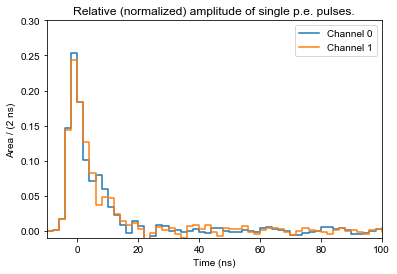

In [61]:
import pickle
from scipy.interpolate import interp1d

spe_pulses_cum = []
spe_ys = []
for ch, fn in enumerate(['170323_103732', '170323_104831']):
    with open('../pulse_shape_single_pe/%s_ch%d.pickle' % (fn, ch) , 'rb') as infile:
        ys = pickle.load(infile)[t_mask]
    plt.plot(spe_ts, ys/ys.sum(), label='Channel %d' % ch, ls='steps')
    spe_ys.append(ys/ys.sum())
    # spe_pulses_cum: list of 2 elements: cumulative distribution for two channels
    spe_pulses_cum.append(
        interp1d(spe_ts, np.cumsum(ys)/ys.sum())
    )
plt.ylim(-0.01, 0.3)
plt.xlabel('Time (ns)')
plt.ylabel('Area / (2 ns)')
plt.legend()
plt.title('Relative (normalized) amplitude of single p.e. pulses.')
plt.xlim(-10, 100)
plt.savefig('plots/pulse_shapes_single.png', bbox_inches='tight', dpi=200)
plt.show()

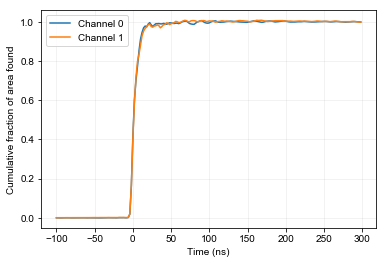

In [62]:
for ch, p in enumerate(spe_pulses_cum):
    plt.plot(spe_ts, p(spe_ts), label='Channel %d' % ch)
plt.grid(alpha=0.2, linestyle='-')
plt.xlabel('Time (ns)')
plt.ylabel('Cumulative fraction of area found')
plt.legend()
plt.show()

What do we need the cumulative fraction for? Well, we input this into the `custom_pmt_pulse_current` in `pax.simulation`. Here is a quick check that all is well. There is just a little shift, but the alignment is quite arbitrary anyway.

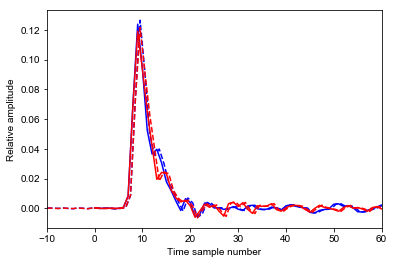

In [63]:
# custom_pmt_pulse_current(pmt_pulse, offset, dt, samples_before, samples_after)
from pax.simulation import custom_pmt_pulse_current
for ch, c in zip([0, 1], ['blue', 'red']):
    plt.plot(custom_pmt_pulse_current(spe_pulses_cum[ch], 0.1, 2, 10, 100), color=c)
    plt.plot(spe_ts * 0.5 + 10 - 0.5, spe_ys[ch] * 0.5, color=c, ls='--')
plt.xlim(-10, 60)
plt.xlabel('Time sample number')
plt.ylabel('Relative amplitude')
plt.show()

## Gain variation

In [64]:
gain_params = []
for ch, fn in enumerate(['170323_103732', '170323_104831']):
    with open('../pulse_shape_single_pe/%s_ch%d_function.pickle' % (fn, ch) , 'rb') as infile:
        _norm, _popt, _perr = pickle.load(infile)
        gain_params.append(np.concatenate([np.array([_norm]), _popt, _perr]))
gain_params = np.array(gain_params)

In [65]:
import scipy

def area_sample(n_values, gain_params, **params):
    params = get_params(params)
    channel = params['pulse_model']
    norm, mu, sigma, _, _ = gain_params[channel]
    lower, upper = (0., 3.)
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    return X.rvs(n_values)

In [66]:
def gaus_trunc(x, mu, sigma):
    return (x > 0) * np.exp( - (x - mu)**2 / (2 * sigma**2))

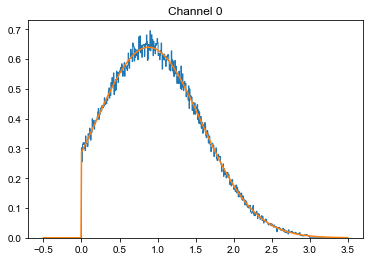

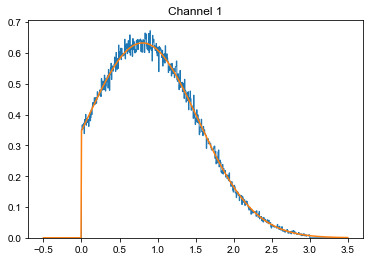

In [67]:
nbins = 600
ran = (-0.5, 3.5)

for channel in (0, 1):
    plt.hist(area_sample(200000, gain_params, pulse_model = channel), bins=nbins, histtype='step', normed=True, range=ran)
    x_plot = np.linspace(*ran, num=nbins)
    y_plot =  gaus_trunc(x_plot,gain_params[channel][1], gain_params[channel][2])
    norm = 1 / (np.sum(y_plot) * (ran[1] - ran[0])) * nbins
    plt.plot(x_plot, norm * y_plot)
    plt.title('Channel %d' % channel)
    plt.show()


# S1 model

## Simulation

In [68]:
import numba

# def split_s1_groups(x, n_x, s1_min, s1_max):
#     """Splits x into groups with uniform(s1_min, s1_max) elements, then return matrix of histograms per group.
#     Returns: integer array (n_x, n_groups)
#     n_x: number of possible values in x. Assumed to be from 0 ... n_x - 1
#     s1_min: minimum S1 number of hits
#     s1_max: maximum S1 number of hits
#     """
#     # We want to exhaust the indices x. Simulate a generous amount of S1 sizes
#     n_s1_est = int(1.5 * 2 * len(x) / (s1_min + s1_max))
#     if 
#     hits_per_s1 = np.random.randint(s1_min, s1_max, size=n_s1_est)
    
#     result = np.zeros((n_x, n_s1_est), dtype=np.int)
#     s1_i = _split_s1_groups(x, hits_per_s1, result)
#     return result[:,:s1_i - 1]

# @numba.jit(nopython=True)
# def _split_s1_groups(x, hits_per_s1, result):
#     s1_i = 0
#     for i in x:
#         if hits_per_s1[s1_i] == 0:
#             s1_i += 1
#             continue
#         result[i, s1_i] += 1
#         hits_per_s1[s1_i] -= 1
#     return s1_i 

def split_s1_groups(x, n_x, areas, **params):
    """Splits x into groups with uniform (s1_min, s1_max) elements, then return matrix of histograms per group.
    Returns: integer array (n_x, n_groups)
    n_x: number of possible values in x. Assumed to be from 0 ... n_x - 1
    s1_min: minimum S1 number of hits
    s1_max: maximum S1 number of hits
    """
    params = get_params(params)
    # We want to exhaust the indices x. Simulate a generous amount of S1 sizes
    n_s1_est = int(1.5 * 2 * len(x) / (params['s1_min'] + params['s1_max']))
    
    if params['s1_sample'] == 'data' and 'xams_data' not in globals():
        print('Warning: data-derived s1 area distribution not possible, reverting to uniform...')
        params['s1_sample'] = 'uniform'
    if params['s1_sample'] == 'uniform':
        pe_per_s1 = (params['s1_max'] - params['s1_min']) * np.random.random(size=n_s1_est) + params['s1_min']
    elif params['s1_sample'] == 'data':
        # Take S1 from the data sample
        s1s_data = xams_data[params['dset']]['s1']
        s1s_data = s1s_data[(s1s_data >= params['s1_min']) & (s1s_data < params['s1_max'])]
        pe_per_s1  = np.random.choice(s1s_data, size=n_s1_est)
    else:
        raise ValueError('Configuration not understood, got this: ', params['s1_sample'])
    result = np.zeros((n_x, n_s1_est), dtype=float)
    # s1_i = _split_s1_groups(x, pe_per_s1, result)
    s1_i = _split_s1_groups(x, pe_per_s1, result, areas)
    return result[:,:s1_i - 1]


@numba.jit(nopython=True)
def _split_s1_groups(x, hits_per_s1, result, areas):
    s1_i = 0
    for photon_i, i in enumerate(x):
        if hits_per_s1[s1_i] < 0:
            s1_i += 1
            continue
        result[i, s1_i] += areas[photon_i]
        hits_per_s1[s1_i] -= areas[photon_i]
    return s1_i 

# %%timeit
# split_s1_groups(np.random.randint(0, 100, size=int(1e6)), 101, 10, 20)

def shift(x, n):
    """Shift the array x n samples to the right, adding zeros to the left."""
    if n > 0:
        return np.pad(x, (n, 0), mode='constant')[:len(x)]
    else:
        return np.pad(x, (0, -n), mode='constant')[-len(x):]



def simulate_s1_pulse(**params):
    # n_photons=int(2e5), 
    """Return (wv_matrix, time_matrix, t_shift vector) for simulated S1s, consisting of n_photons in total
    """
    params = get_params(params)
    n_photons = params['n_photons']

    ##
    # Make matrix (n_samples, n_waveforms) of pulse waveforms with various shifts
    ##
    i_noshift = np.searchsorted(spe_t_edges, [0])[0]    # Index corresponding to no shift in the waveform
    y = spe_ys[params['pulse_model']]  # This is the CHANNEL
    # This is a matrix filled with waveforms, ordered by their SHIFT.
    # So, these are all just model waveforms and will be selected later
    wv_matrix = np.vstack([shift(y, i - i_noshift) 
                           for i in range(len(spe_ts))]).T 
    
    ##
    # Simulate S1 pulse times, convert to index
    ##
    times = np.zeros(n_photons)

    n_singlets = np.random.binomial(n=n_photons, p=params['fs']) # We randomly select if the photon came from a singlet
                                                                 # or triplet decay
    # Time is distributed according to exponential distribution
    # This is the TRUE time of all the photons generated, assuming time=0  is the time of the interaction
    times += np.concatenate([
        np.random.exponential(params['t1'], n_singlets),
        np.random.exponential(params['t3'], n_photons - n_singlets)
    ])
    # Since `times` is now sorted in (singlet, triplet), shuffle them
    np.random.shuffle(times)
    
    # Here we start taking into account detector physics: the transit time spread (simulated as normal dist.)
    times += np.random.normal(0, params['tts'], size=n_photons)
    
    # Find the bin that the photon would be in if it were sampled.
    indices = np.searchsorted(spe_t_edges, times)

    # Now, we delete all the photons that are outside of the bin range and re-match to the bin centers
    # (Check the searchsorted documentation)
    indices = indices[~((indices == 0) | (indices == len(spe_t_edges)))] - 1

    # This is the new amount of photons simulated
    if len(indices) < n_photons:
        # print('Warning: I just threw away %d photons...' % (n_photons - len(indices)))
        n_photons = len(indices)
    
    # TODO: gain variation simulation
    areas = area_sample(n_photons, gain_params, **params)
    
    # NOTE do we also want to take the difference between the two channels into accont?

    ##
    # Build instruction matrix, simulate waveforms
    ##
    # So far, we've just been simulating a bunch of photons (very many).
    # We are now going to split this into S1s: the split will be made at a random point between s1_min and s1_max.
    # `index_matrix` is a matrix split into groups forming S1s. 
    # index_matrix = split_s1_groups(indices, len(spe_t_edges) - 1, params['s1_min'], params['s1_max'])

    index_matrix = split_s1_groups(indices, len(spe_t_edges) - 1, areas, **params)

    # Now, index_matrix[:, 0] contains a list of number of entries for the shift for each timestamp in bin
    n_s1 = index_matrix.shape[1]
    
    # return wv_matrix, index_matrix
    # Remember that wv_matrix is a matrix of waveforms, each element at position i of which is shifted i samples
    s1_waveforms = np.dot(wv_matrix, index_matrix)
    # return s1_waveforms

    ##
    # Alignment based on maximum sample, compute average pulse
    ##
    time_matrix, t_shift = aligned_time_matrix(spe_ts, s1_waveforms)    
    return s1_waveforms, time_matrix, t_shift

def aligned_time_matrix(ts, wv_matrix, mode = '10p'):
    """Return time matrix that would align waveforms im wv_matrix"""
    n_s1 = wv_matrix.shape[1]

    if mode == 'max':
        # Find the position of maximum sample and match its times
        t_shift = ts[np.argmax(wv_matrix, axis=0)]
    elif mode == '10p':
        fraction_reached = np.cumsum(wv_matrix, axis=0) / np.sum(wv_matrix, axis=0)
        # Get the sample where 10% is reached by taking the sample closest to the 10% point
        # This is as good as you can get without introducing fractional samples (which may be an improvement)
        # TODO get interpolation in here
        distance_to_10p_point = np.abs(fraction_reached - 0.1)
        t_shift = ts[np.argmin(distance_to_10p_point, axis=0)]
    
    time_matrix = np.repeat(ts, n_s1).reshape(wv_matrix.shape)
    time_matrix -= t_shift[np.newaxis,:]
    return time_matrix, t_shift

def average_pulse(time_matrix, wv_matrix):
    """Return average pulse, given time and waveform matrices"""
    h, _ = np.histogram(time_matrix, bins=spe_t_edges, weights=wv_matrix)
    h /= h.sum()
    return h

def s1_average_pulse_model(*args, **kwargs):
    wv_matrix, time_matrix, _ = simulate_s1_pulse(*args, **kwargs)
    return average_pulse(time_matrix, wv_matrix)


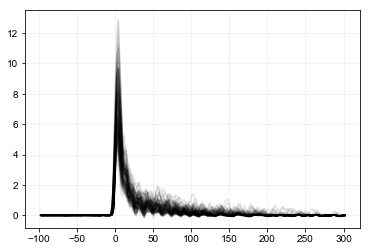

In [69]:
s1_wvs, tmat, _ = simulate_s1_pulse(n_photons=int(2e5), t3=1, t1=50, tts=1, fs=0.5, dset='nr')
for i in range(100):
    plt.plot(tmat[:, i], s1_wvs[:, i], alpha=0.1, c='k')
plt.grid(alpha=0.2, linestyle='-')

Here is what we get out.
`wv_matrix` is a matrix containing the y-coordinates of the waveforms. The columns are the individual waveforms, to get the first waveform, go `wv_matrix[:, 0]`. `time_matrix` is the same thing except for it contains the times. `t_shift_vector` contains the shift of the waveform in ns (based on pulse times).

## Statistical errors

Here we simulate statistical errors by simulating `n_data_s1s` and then performing bootstrap trials. The conclusion:....

In [70]:
def s1_models_resample(*args, n_data_s1s=1000, bootstrap_trials=10, **kwargs):
    """Return bootstrap_trials waveform templates from sampling n_data_s1s s1s"""
    wv_matrix, time_matrix, _ = simulate_s1_pulse(*args, **kwargs)
    n_s1s = wv_matrix.shape[1]
    
    waveform_templates = np.zeros((len(spe_ts), bootstrap_trials))

    for i in range(bootstrap_trials):
        new_indices = np.random.randint(n_s1s, size=n_data_s1s)

        waveform_templates[:, i] = average_pulse(time_matrix[:, new_indices], 
                                                 wv_matrix[:, new_indices])
    
    return waveform_templates

def sigmas_plot(x, q, color='b', **kwargs):
    for n_sigma, alpha in [(1,0.5), (2, 0.1)]:
        plt.fill_between(x,
                         np.percentile(q, 100 * stats.norm.cdf(-n_sigma), axis=1),
                         np.percentile(q, 100 * stats.norm.cdf(n_sigma), axis=1),
                         alpha=alpha, linewidth=0, color=color, step='mid')
    plt.plot(x, 
             np.percentile(q, 50, axis=1), 
             color=color, linestyle='-', alpha=0.5, linewidth=1, **kwargs)

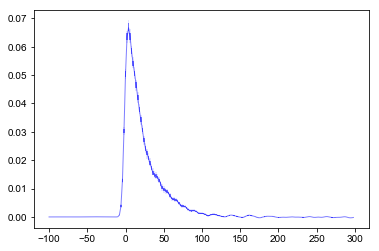

In [71]:
waveform_templates = s1_models_resample(n_data_s1s=100, s1_min=50, s1_max=60, bootstrap_trials=100)
sigmas_plot(spe_ts, waveform_templates)

Statistical errors are negligible if you have more than a few hundred waveforms.

## Systematic errors

In [72]:
import itertools

def s1_models_error(*args, shifts=None, **kwargs):
    '''
    Compute the error on the S1 waveform given errors on specific parameters.
    This will compute the S1 model for parameter +error, +0, and -error.
    All combinations of paramters are tried.
    `shifts` is a dict containting the allowed shift (+/-) for each model parameter.
    `*args` and `**kwargs` will be passed to `s1_average_pulse_model` to compute the base model.
    This function can also be used for getting the difference in pulse model for channel 0 and 1.
    '''
    if shifts is None:
        # Default uncertainty: in pulse model and in TTS
        shifts = dict(tts=0.5, pulse_model=[0,1])
    
    base_model = s1_average_pulse_model(*args, **kwargs)
    
    # Allow specifying a single +- amplitude of variation
    for p, shift_values in shifts.items():
        if isinstance(shift_values, (float, int)):
            shifts[p] = kwargs.get(p, default_params[p]) + np.array([-1, 0, 1]) * shift_values
    
    shift_pars = sorted(shifts.keys())
    shift_values = [shifts[k] for k in shift_pars]
    # shift_value_combs is a list of paramters that will be tried to compute the average pulse.
    # Contains all combintations: (+, 0, -) for all the parameters. ((3n)^2 for n number of parameters.)
    shift_value_combs = list(itertools.product(*shift_values))
    
    alt_models = []
    for vs in shift_value_combs:
        kw = dict()
        kw.update(kwargs)
        for i, p in enumerate(shift_pars):
            kw[p] = vs[i]        
        alt_models.append(s1_average_pulse_model(*args, **kw))
    
    
    alt_models = np.vstack(alt_models)
    # Hmmm. this seems like an upper estimate of the error, no?
    # ask jelle
    minus = np.min(alt_models, axis=0)
    plus = np.max(alt_models, axis=0)    
    return minus, base_model, plus
    
#     return [s1_average_pulse_model(*args, **kwargs) 
#              for q in [-tts_sigma, 0, tts_sigma]]


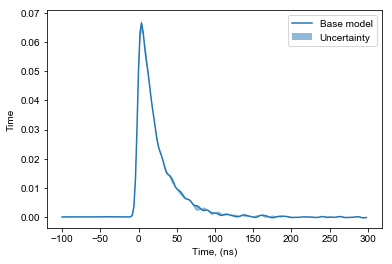

In [73]:
minus, base, plus = s1_models_error()
plt.fill_between(spe_ts, minus, plus, alpha=0.5, linewidth=0, label='Uncertainty')
plt.plot(spe_ts, base, label='Base model')
plt.xlabel('Time, (ns)')
plt.ylabel('Time')
plt.legend()
plt.show()


# Real data waveforms

## Read the data

Here we read the S1 data for three (highfield) datasets: NR, ER and BG_NR. We store it in the form of a dict (keys: er, nr, bg_nr). Each dict item is an array containing the waveforms (per row).

In [74]:
xams_data = dict()
xams_data['nr'], xams_data['er'], xams_data['bg_nr'] = pickle.load(open('highfield_dataframes.pickle', 'rb'))

xams_s1s = dict()
# Get pulse waveforms to matrix rather than object column
for k, d in xams_data.items():
    xams_s1s[k] = np.array([x for x in d['s1_pulse']])
    del d['s1_pulse']

Here's an example waveform

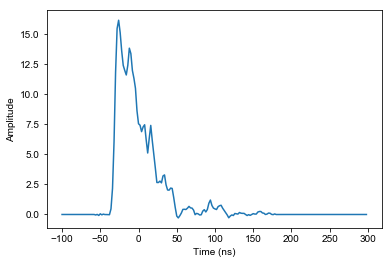

In [75]:
plt.plot(spe_ts, xams_s1s['nr'][0])
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude')
plt.show()

## Alignment, averaging, bootstrapping

In [76]:
def real_s1_wv(**params):
    """Return average S1 waveform, number of S1s it was constructed from"""
    params = get_params(params)
    
    areas = xams_data[params['dset']]['s1'].values
    mask = (params['s1_min'] < areas) & (areas < params['s1_max'])

    # Could now derive distribution, I'll just assume uniform for the moment.
    # Hist1d(areas[mask],
    #        bins=np.linspace(params['s1_min'], params['s1_max'], 100)).plot()

    n_data_s1s = mask.sum()
    wvs = xams_s1s[params['dset']][mask].T
    tmat, _ = aligned_time_matrix(spe_ts, wvs)
    real_s1_avg =  average_pulse(tmat, wvs)
    
    return real_s1_avg, n_data_s1s

In [149]:
def real_s1_wv_sigma(bootstrap_trials = 25, **params):
    """Take data S1s, bootstrap sample, then check what the variance is"""
    params = get_params(params)
    
    time_matrix, wv_matrix = real_s1_wv_matrix(**params)
    n_s1s = wv_matrix.shape[1]
    waveform_templates = np.zeros((len(spe_ts), bootstrap_trials))

    for i in range(bootstrap_trials):
        new_indices = np.random.randint(n_s1s, size=n_s1s)

        waveform_templates[:, i] = average_pulse(time_matrix[:, new_indices], 
                                                 wv_matrix[:, new_indices])
        
    
    return np.std(waveform_templates, axis=1)

In [78]:
def real_s1_wv_matrix(**params):
    """Return the aligned time matrix and waveform matrix."""
    params = get_params(params)
    
    areas = xams_data[params['dset']]['s1'].values
    mask = (params['s1_min'] < areas) & (areas < params['s1_max'])

    # Could now derive distribution, I'll just assume uniform for the moment.
    # Hist1d(areas[mask],
    #        bins=np.linspace(params['s1_min'], params['s1_max'], 100)).plot()

    n_data_s1s = mask.sum()
    wvs = xams_s1s[params['dset']][mask].T
    tmat, _ = aligned_time_matrix(spe_ts, wvs)
        
    return tmat, wvs

## Plot

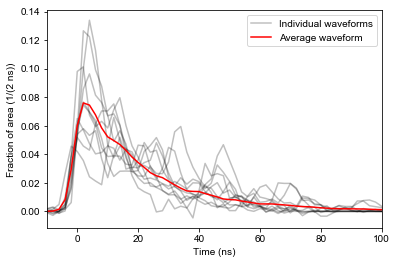

In [79]:
s1_range = (30, 40)
dset  ='nr'
n_singles = 10

ydata, n_data_s1s = real_s1_wv(s1_min = s1_range[0], s1_max = s1_range[1], dset = dset)
tmat, wvs = real_s1_wv_matrix(s1_min = s1_range[0], s1_max = s1_range[1], dset=dset)

for i in range(n_singles):
    # legend hack
    if i == 0:
        plt.plot(tmat[:, i], wvs[:, i] / np.sum(wvs[:, i]), color='black', alpha=0.25, label='Individual waveforms')
    else:
        plt.plot(tmat[:, i], wvs[:, i] / np.sum(wvs[:, i]), color='black', alpha=0.25)
plt.plot(spe_ts, ydata, lw=1.5, color='red', label='Average waveform')
plt.xlim(-10, 100)
plt.xlabel('Time (ns)')
plt.ylabel('Fraction of area (1/(2 ns))')
plt.legend()
plt.savefig('average_wv.png', bbox_inches='tight', dpi=200)
plt.show()

In [80]:
s1_bins = np.linspace(0, 100, 11)

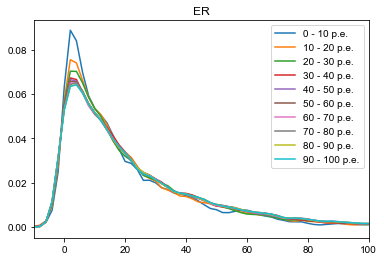

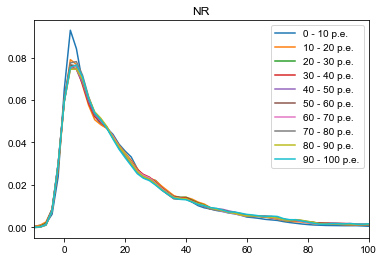

In [81]:
for left, right in zip(s1_bins[:-1], s1_bins[1:]):
    ydata, n_data_s1s = real_s1_wv(s1_min = left, s1_max = right, dset = 'er')
    plt.plot(spe_ts, ydata, label = '%d - %d p.e.' % (left, right))
    #plt.title('Average waveform %.1f - %.1f p.e., %d events.' % (left, right, n_data_s1s))
    #plt.show()
plt.xlim(-10, 100)
plt.title('ER')
plt.legend()
plt.show()

for left, right in zip(s1_bins[:-1], s1_bins[1:]):
    ydata, n_data_s1s = real_s1_wv(s1_min = left, s1_max = right, dset='nr')
    plt.plot(spe_ts, ydata, label = '%d - %d p.e.' % (left, right))
    #plt.title('Average waveform %.1f - %.1f p.e., %d events.' % (left, right, n_data_s1s))
    #plt.show()
plt.xlim(-10, 100)
plt.title('NR')
plt.legend()
plt.show()

# Model-data comparison

## Sigma and residuals

In [139]:
def residuals(ydata, minus, base, plus, **params):
    params = get_params(params)
    sigma = get_sigma(minus, base, plus, **params)
    if 0. in sigma:
        zero_positions = np.where(sigma == 0)
        print('Warning: found zero in error array at positions: ', zero_positions)
        print('Replacing with infinite error instead...')
        for pos in zero_positions:
            sigma[pos] = np.inf
    return (ydata - base) / sigma

def get_sigma(minus, base, plus, **params):
    params = get_params(params)
    sigma_syst = np.abs(plus - minus)/2 + params['error_offset'] + params['error_pct'] * np.abs(base)
    if params['neglect_statistical']:
        print('Neglect!')
        return sigma_syst
    sigma_stat = real_s1_wv_sigma(bootstrap_trials = 25, **params)
    sigma = np.sqrt(sigma_syst**2 + sigma_stat**2)
    return sigma
   

## Plotting

In [225]:
def comparison_plot(ydata, minus, base, plus, log=False, **params):
    params = get_params(params)
    sigmas = get_sigma(minus, base, plus, **params)

    # large subplot
    ax2 = plt.subplot2grid((3,1), (2,0))
    ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2, sharex=ax2)

    #f, (ax1, ax2) = plt.subplots(2, sharex=True)
    plt.sca(ax1)
    # plt.fill_between(spe_ts, minus, plus, alpha=0.5, linewidth=0, step='mid')
    plt.fill_between(spe_ts, base - sigmas, base + sigmas,
                     alpha=0.5, linewidth=0, step='mid')
    plt.plot(spe_ts, base, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')

    plt.grid(alpha=0.1, linestyle='-', which='both')
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.ylabel("Fraction of amplitude")
    plt.axhline(0, c='k', alpha=0.5)
    leg = plt.legend(loc='upper right', numpoints=1)
    leg.get_frame().set_linewidth(0.0)
    leg.get_frame().set_alpha(0.5)
    if log:
        plt.yscale('log')
        plt.ylim(1e-5, 1e-1)
    else:
        plt.ylim(0, None)

    #ax1.set_xticklabels([])

    # Add residuals
    plt.sca(ax2)
    plt.subplot2grid((3,1), (2,0), sharex=ax1)
    plt.xlim(params['t_min'], params['t_max'])

    res = residuals(ydata, minus, base, plus, **params)
    
    plt.plot(spe_ts, res,
             linestyle='', marker='x', c='k', markersize=3)
    plt.ylim(-3, 3)
    plt.grid(which='both', linestyle='-', alpha=0.1)
    plt.axhline(0, c='k', alpha=0.5)

    plt.ylabel("Residual")
    plt.xlabel("Time since alignment point")
#     plt.text(#plt.xlim()[1] * 0.5, plt.ylim()[1] * 0.6,
#              60, 2,
#              'Mean abs. res.: %0.3f' % np.abs(res).mean())

    plt.tight_layout()
    plt.gcf().subplots_adjust(0,0,1,1,0,0)

def comparison_plot_2(ydata, minus, base, plus, **params):
    params = get_params(params)
    res = residuals(ydata, minus, base, plus, **params)
    sigmas = get_sigma(minus, base, plus, **params)
    
#     plt.fill_between(spe_ts, minus - params['error_offset'], plus + params['error_offset'],
#                      alpha=0.5, linewidth=0, step='mid')
    plt.fill_between(spe_ts, base - sigmas, base + sigmas,
                     alpha=0.5, linewidth=0, step='mid')
    plt.plot(spe_ts, base, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')
    plt.yscale('log')
    plt.ylim(2e-5, 1e-1)
    plt.ylabel("Fraction of amplitude")
    plt.xlabel('Time (ns)')
    for _l in (params['t_min'], params['t_max']):
        plt.axvline(_l, ls='dotted', color='black')
    plt.twinx()
    plt.plot(spe_ts, np.abs(res), color='red')
    plt.ylabel('Residual / error')
    plt.ylim(0)
    plt.xlim(params['t_min'] - 20, params['t_max'] + 50)
    
    res = res[(spe_ts >= params['t_min']) & (spe_ts < params['t_max'])]
    chi2 = sum(res**2) / len(spe_ts[(spe_ts >= params['t_min']) & (spe_ts < params['t_max'])])
    print('chi2 = %f' % chi2)

## Residuals function

In [197]:
def gof(verbose=True, mode = 'chi2_ndf', **params):
    '''
    Get the value to minimize given the parameters
    '''
    params = get_params(params)
    
    # Do not allow unphysical values
    if params['t1'] < 0 or params['t3'] < 0 or not (0 <= params['fs'] <= 1):
        result = float('inf')
    else:
        ydata, _ = real_s1_wv(**params)
        # By default, the errors are set to: [0,1] for pulse model, 1.0 for tts
        minus, base, plus = s1_models_error(**params)
        res = residuals(ydata, minus, base, plus, **params)
        assert len(res) == len(spe_ts)
        res = res[(spe_ts >= params['t_min']) & (spe_ts < params['t_max'])]
        if mode == 'mean':
            result = np.abs(res).mean()
        elif mode == 'median':
            result = np.median(np.abs(res))
        elif mode == 'chi2':
            result = np.sum(res**2)
        elif mode == 'chi2_ndf':
            result = 1/len(res) *np.sum(res**2)
        elif mode == 'res':
            result = res
        else:
            raise ValueError('Mode unknown, fot this: %s' % mode)
    if verbose and (mode != 'res'):
        print('gof={gof}, fs={fs}, t1={t1}, t3={t3}, tts={tts}'.format(gof=result, **params))
    return result

def gof_repeat(iterations, verbose=True, mode = 'chi2_ndf', metamode = 'median', **params):
    params = get_params(params)
    if params['t1'] < 0 or params['t3'] < 0 or not (0 <= params['fs'] <= 1):
        result = float('inf')
    else:
        gofs = np.array([gof(verbose=False, mode = mode, **params) for _ in range(iterations)])
        if metamode == 'median':
            result = np.median(gofs)
        elif metamode == 'mean':
            result = np.mean(gofs)
    if verbose:
        print('gof={gof}, fs={fs}, t1={t1}, t3={t3}, tts={tts}'.format(gof=result, **params))
    return result    


In [106]:
from copy import deepcopy
def gof_simultaneous(fs_er, fs_nr, verbose=True, mode='mean', **params):
    params = get_params(params)
    params_er = deepcopy(params)
    params_nr = deepcopy(params)
    params_er['dset'] = 'er'
    params_nr['dset'] = 'nr'
    params_er['fs'] = fs_er
    params_nr['fs'] = fs_nr
    gof_er = gof(verbose=False, mode=mode, **params_er)
    gof_nr = gof(verbose=False, mode=mode, **params_nr)
    if verbose:
        print('gof_er={gof_er}, gof_nr={gof_nr}, fs_er={fs_er}, fs_nr={fs_nr} t1={t1}, t3={t3}, tts={tts}'.format(
            gof_er=gof_er, gof_nr=gof_nr, fs_er = params_er['fs'], fs_nr = params_nr['fs'], **params))    
    return gof_er + gof_nr

## The error definition

In earlier analyses, the error definition seemed to cause instabilities in the fit procedure. Here, we load `cust_params` that are close to a fit optimum. Here we check what a change in error definition does. Do we need an ad-hoc error, or can we suffice with an error based on systematics and statistics?

In [173]:
cust_params = dict(
    s1_min = 30,
    s1_max = 100,
    dset = 'er',
    fs = 0.19752269,
    t3 = 25.31125617,
    tts = 1.69178651
)

Try different settings and check their spread in chi2

In [130]:
iterations = 100
gofs1 = [gof(mode='chi2_ndf', verbose=False, error_offset = 0., error_pct = 0., **cust_params) for i in range(iterations)]
gofs2 = [gof(mode='chi2_ndf', verbose=False, error_offset = 1e-5, error_pct = 0., **cust_params) for i in range(iterations)]
gofs3 = [gof(mode='chi2_ndf', verbose=False, error_offset = 0., error_pct = 0.5e-2, **cust_params) for i in range(iterations)]
gofs4 = [gof(mode='chi2_ndf', verbose=False, error_offset = 1e-5, error_pct = 0.5e-2, **cust_params) for i in range(iterations)]

5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168
5168


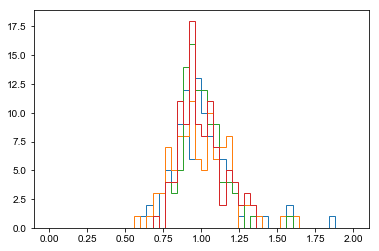

In [137]:
for gofs in [gofs1, gofs2, gofs3, gofs4]:
    plt.hist(gofs / np.mean(gofs), histtype='step', range=(0, 2), bins=50)

Aha, the error pct and offset does not do so much! What about turning off the statistical errors?

In [143]:
gofs5 = [gof(mode='chi2_ndf', verbose=False, error_offset = 0., error_pct = 0., neglect_statistical = True,
             **cust_params) for i in range(iterations)]
gofs1 = [gof(mode='chi2_ndf', verbose=False, error_offset = 0., error_pct = 0., neglect_statistical = False,
             **cust_params) for i in range(iterations)]

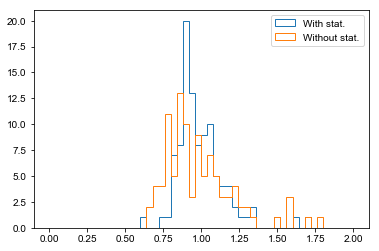

In [146]:
plt.hist(gofs1 / np.mean(gofs1), histtype='step', range=(0, 2), bins=50, label='With stat.')
plt.hist(gofs5 / np.mean(gofs5), histtype='step', range=(0, 2), bins=50, label='Without stat.')
plt.legend()
plt.show()

Conclusion: it seems that the statistical error cannot be neglected! Including the statistical error makes everything more stable, yay! This is probably the highest stats that we'll get.

### Number of photons

How many photons do we need? And how does the spread in chi2 depend on the number of photons simulated? If it has any influence this is bad.

In [168]:
n_photons_scan = np.array([int(_i) for _i in np.logspace(4,5.3, 6)])

In [170]:
iterations = 40

const_gofs = []
for n_photons in n_photons_scan:
    print(n_photons)
    const_gofs.append([gof(verbose = False, mode='chi2_ndf', n_photons = n_photons, **cust_params)
                       for _ in range(iterations)])

10000
18197
33113
60255
109647
199526


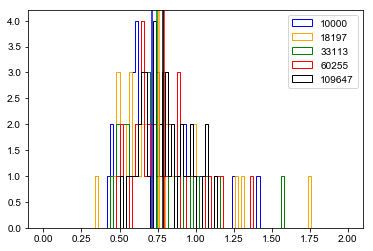

In [174]:
for gofs, n_photons, c in zip(const_gofs, n_photons_scan, ['blue', 'orange', 'green', 'red', 'black']):
    plt.hist(gofs, label="%d" % n_photons, histtype='step', range=(0, 2), bins=100, color = c)
    plt.axvline(np.mean(gofs), color = c)
plt.legend()
plt.show()

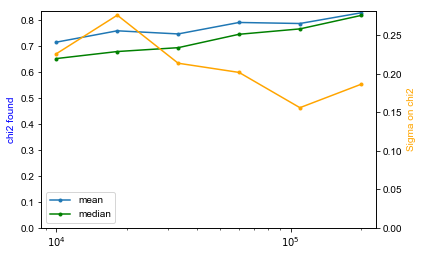

In [182]:
plt.plot(n_photons_scan, np.average(const_gofs, axis=1), marker='.', label='mean')
plt.plot(n_photons_scan, np.median(const_gofs, axis=1), marker='.', color='green', label='median')
plt.ylim(0)
plt.legend()
plt.ylabel('chi2 found', color='blue')
plt.twinx()
plt.plot(n_photons_scan, np.std(const_gofs, axis = 1), marker='.', color='orange')
plt.ylabel('Sigma on chi2', color='orange')
plt.ylim(0)
plt.xscale('log')
plt.xlabel('Number of photons simulated')

Hmmm. Conclusion? For now, it looks like 10^5 is as good as twice that. Do we need even more?

## Fit three parameters

### Settings

In [194]:
cust_params = dict(
    s1_min = 30,
    s1_max = 100,
    dset = 'er',
    n_photons = int(1e5)
)

### ER fit

Fit to the data.

In [188]:
from scipy import optimize
optresult = optimize.minimize(
    lambda x: gof(fs=x[0], t3=x[1], tts=x[2], **cust_params),
    [0.2, 25., 2.],
    options=dict(maxfev=1000),
    method='Powell',
)
print('Done')

gof=1.1138057210180978, fs=0.2, t1=3.1, t3=25.0, tts=2.0
gof=0.9231701054297754, fs=0.2, t1=3.1, t3=25.0, tts=2.0
gof=inf, fs=1.2, t1=3.1, t3=25.0, tts=2.0
gof=inf, fs=-1.418034, t1=3.1, t3=25.0, tts=2.0
gof=1.0463237847291709, fs=0.2, t1=3.1, t3=25.0, tts=2.0
gof=inf, fs=-0.418033974844, t1=3.1, t3=25.0, tts=2.0


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


gof=76.12868795580385, fs=0.581966, t1=3.1, t3=25.0, tts=2.0
gof=inf, fs=-0.036067965235263316, t1=3.1, t3=25.0, tts=2.0
gof=17.200970008698047, fs=0.34589802515600004, t1=3.1, t3=25.0, tts=2.0
gof=8.980014002087229, fs=0.12070076105146474, t1=3.1, t3=25.0, tts=2.0
gof=1.8301166373469462, fs=0.21379748266245152, t1=3.1, t3=25.0, tts=2.0
gof=0.718975651493102, fs=0.19004062624773474, t1=3.1, t3=25.0, tts=2.0
gof=1.3490908140239148, fs=0.16355515529817627, t1=3.1, t3=25.0, tts=2.0
gof=0.9456241589635819, fs=0.18444939785316078, t1=3.1, t3=25.0, tts=2.0
gof=0.7032857147479091, fs=0.19153877891169566, t1=3.1, t3=25.0, tts=2.0
gof=0.8827465909788706, fs=0.1920245197391207, t1=3.1, t3=25.0, tts=2.0
gof=0.7948764755088265, fs=0.19081704574672123, t1=3.1, t3=25.0, tts=2.0
gof=0.9744263199494394, fs=0.19126310138160305, t1=3.1, t3=25.0, tts=2.0
gof=1.0398980499126218, fs=0.1917243153925839, t1=3.1, t3=25.0, tts=2.0
gof=0.7721468205949311, fs=0.1914334794682363, t1=3.1, t3=25.0, tts=2.0
gof=1.00

[  0.18572451  25.46475378   1.06148188]


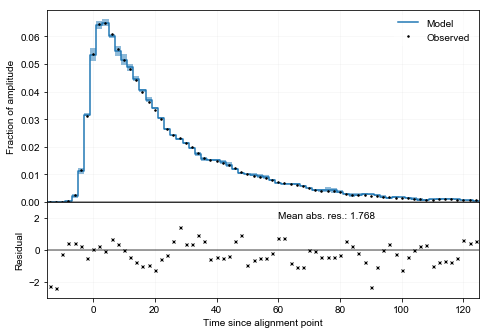

chi2 = 0.611522


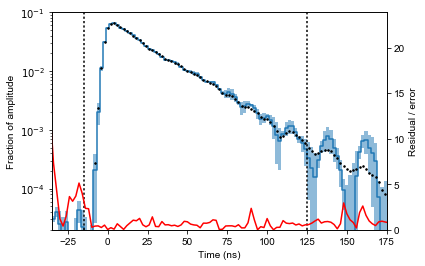

In [201]:
fit = optresult.x
print(fit)
ydata, _ = real_s1_wv(**cust_params)
minus, base, plus = s1_models_error(fs=fit[0], t3=fit[1], tts = fit[2], **cust_params)
comparison_plot(ydata, minus, base, plus, **cust_params)
plt.show()
comparison_plot_2(ydata, minus, base, plus, **cust_params)
plt.show()

### Repeat and take median?

In [ ]:
iterations = 20
gofs_1 = [gof_repeat(1,fs=fit[0], t3=fit[1], tts = fit[2], **cust_params) for _ in range(iterations)]
gofs_2 = [gof_repeat(2,fs=fit[0], t3=fit[1], tts = fit[2], **cust_params) for _ in range(iterations)]
# gofs_3 = [gof_repeat(3,fs=fit[0], t3=fit[1], tts = fit[2], **cust_params) for _ in range(iterations)]
# gofs_4 = [gof_repeat(4,fs=fit[0], t3=fit[1], tts = fit[2], **cust_params) for _ in range(iterations)]
gofs_5 = [gof_repeat(5,fs=fit[0], t3=fit[1], tts = fit[2], **cust_params) for _ in range(iterations)]

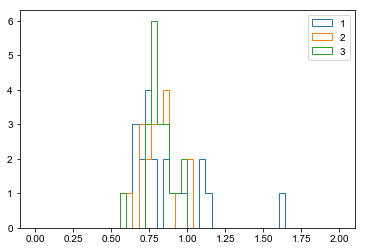

In [211]:
for i, gofs in enumerate([gofs_1, gofs_2, gofs_5]):
    plt.hist(gofs, bins=50, range=(0, 2), histtype='step', label='%d' % (i+1))
plt.legend()
plt.show()

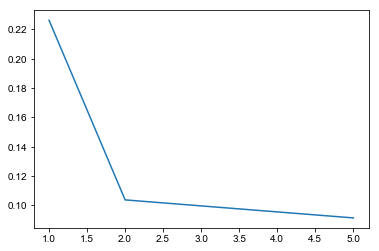

In [212]:
plt.plot([1, 2, 5], [np.std(gofs) for gofs in [gofs_1, gofs_2, gofs_5]])

### Repeat and take median

Here we repeat the gofs a couple of times, take the median, and then mimimize that. Ain't I clever? Except it totally maskes that I don't know where this comes from exactly...

By the way, we also take the previous fit as starting values. 

In [215]:
repeat = 3

In [ ]:
optimize.show_optionstions(solver='minimize', method='Powell')

In [216]:
optresult = optimize.minimize(
    lambda x: gof_repeat(repeat, fs=x[0], t3=x[1], tts=x[2], **cust_params),
    fit,
    options=dict(maxfev=1000
                 # maxiter
                 # disp (bool)
                 # direc (initial direction vectors)
                ),
    method='Powell',
)
print('Done')

gof=0.9249355158584385, fs=0.18572450652813277, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=0.7061973967899041, fs=0.18572450652813277, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=inf, fs=1.1857245065281328, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=inf, fs=-1.4323094934718672, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=0.737448493529934, fs=0.18572450652813277, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=inf, fs=-0.43230946831586725, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


gof=62.71456408422516, fs=0.5676905065281328, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=inf, fs=-0.050343458707130556, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=15.332419586364585, fs=0.3316225316841328, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=17.647143939890995, fs=0.06891051984956083, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=1.2559706509179516, fs=0.2049944499252993, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=1.6466491940846475, fs=0.1720620149726873, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=0.66960896783878, fs=0.19061841622170342, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=0.70036661584787, fs=0.1905694771147677, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=0.7464185920010472, fs=0.19610957231133114, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=0.9203722980653857, fs=0.19271585114863415, t1=3.1, t3=25.46475378216084, tts=1.0614818801792683
gof=0.8177940

[  0.19382575  25.35017687   1.16652153]


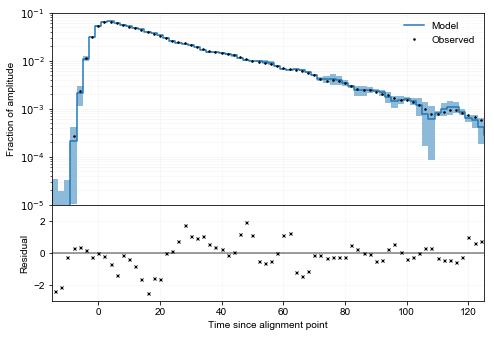

chi2 = 0.759650


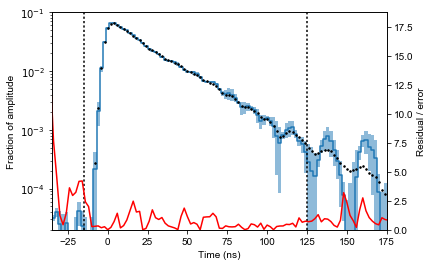

In [226]:
fit = optresult.x
print(fit)
ydata, _ = real_s1_wv(**cust_params)
minus, base, plus = s1_models_error(fs=fit[0], t3=fit[1], tts = fit[2], **cust_params)
comparison_plot(ydata, minus, base, plus, log=True, **cust_params)
plt.savefig('plots/ER_fit_log.png', bbox_inches='tight', dpi = 200)
plt.show()
comparison_plot_2(ydata, minus, base, plus, **cust_params)
plt.show()

### NR

In [227]:
cust_params['dset'] = 'nr'

In [229]:
from scipy import optimize
optresult = optimize.minimize(
    lambda x: gof(fs=x[0], t3=x[1], tts=x[2], **cust_params),
    [0.2, 25., 2.],
    options=dict(maxfev=1000),
    method='Powell',
)
print('Done')

gof=13.159253403612661, fs=0.2, t1=3.1, t3=25.0, tts=2.0
gof=11.451275605802891, fs=0.2, t1=3.1, t3=25.0, tts=2.0
gof=inf, fs=1.2, t1=3.1, t3=25.0, tts=2.0
gof=inf, fs=-1.418034, t1=3.1, t3=25.0, tts=2.0
gof=10.826443195572631, fs=0.2, t1=3.1, t3=25.0, tts=2.0
gof=inf, fs=-0.418033974844, t1=3.1, t3=25.0, tts=2.0


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


gof=35.4311845414091, fs=0.581966, t1=3.1, t3=25.0, tts=2.0
gof=inf, fs=-0.036067965235263316, t1=3.1, t3=25.0, tts=2.0
gof=3.750283486319269, fs=0.34589802515600004, t1=3.1, t3=25.0, tts=2.0
gof=7.777530475904081, fs=0.32364771328245046, t1=3.1, t3=25.0, tts=2.0
gof=12.214509399926046, fs=0.43606796523526337, t1=3.1, t3=25.0, tts=2.0
gof=13.16308173623988, fs=0.3803398764883159, t1=3.1, t3=25.0, tts=2.0
gof=7.602421151711718, fs=0.3590536413419994, t1=3.1, t3=25.0, tts=2.0
gof=5.805634818471212, fs=0.3415354656668702, t1=3.1, t3=25.0, tts=2.0
gof=6.145813848950427, fs=0.34911856533197716, t1=3.1, t3=25.0, tts=2.0
gof=6.651370266810731, fs=0.34443904489444005, t1=3.1, t3=25.0, tts=2.0
gof=7.770077701102463, fs=0.34735700541756004, t1=3.1, t3=25.0, tts=2.0
gof=6.597995841066473, fs=0.34589802515600004, t1=3.1, t3=25.0, tts=2.0
gof=10.526721391276132, fs=0.34589802515600004, t1=3.1, t3=26.0, tts=2.0
gof=5.239944776396426, fs=0.34589802515600004, t1=3.1, t3=23.381966, tts=2.0
gof=5.373094

[  0.25949181  22.90804497   1.56472904]


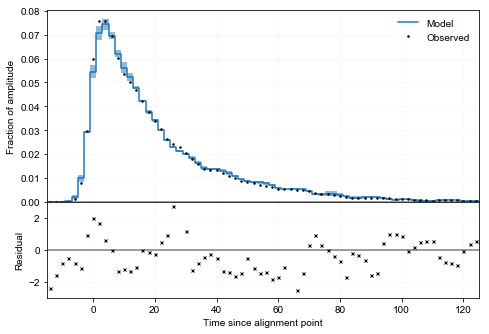

chi2 = 1.896165


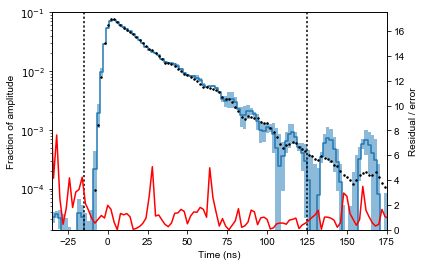

In [230]:
fit = optresult.x
print(fit)
ydata, _ = real_s1_wv(**cust_params)
minus, base, plus = s1_models_error(fs=fit[0], t3=fit[1], tts = fit[2], **cust_params)
comparison_plot(ydata, minus, base, plus, log=False, **cust_params)
plt.savefig('plots/NR_fit.png', bbox_inches='tight', dpi = 200)
plt.show()
comparison_plot_2(ydata, minus, base, plus, **cust_params)
plt.show()

In [232]:
repeat = 3

In [233]:
from scipy import optimize
optresult = optimize.minimize(
    lambda x: gof_repeat(repeat, fs=x[0], t3=x[1], tts=x[2], **cust_params),
    fit,
    options=dict(maxfev=1000),
    method='Powell',
)
print('Done')

gof=1.8955144163721631, fs=0.25949180911169484, t1=3.1, t3=22.908044974271082, tts=1.564729038929644
gof=1.5438549595960707, fs=0.25949180911169484, t1=3.1, t3=22.908044974271082, tts=1.564729038929644
gof=inf, fs=1.259491809111695, t1=3.1, t3=22.908044974271082, tts=1.564729038929644
gof=inf, fs=-1.358542190888305, t1=3.1, t3=22.908044974271082, tts=1.564729038929644
gof=1.6823710659108475, fs=0.25949180911169484, t1=3.1, t3=22.908044974271082, tts=1.564729038929644
gof=inf, fs=-0.3585421657323052, t1=3.1, t3=22.908044974271082, tts=1.564729038929644


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


gof=50.8018785992, fs=0.6414578091116949, t1=3.1, t3=22.908044974271082, tts=1.564729038929644
gof=38.855124618276704, fs=0.02342384387643151, t1=3.1, t3=22.908044974271082, tts=1.564729038929644
gof=3.0524099055686342, fs=0.311559482706626, t1=3.1, t3=22.908044974271082, tts=1.564729038929644
gof=1.5847086033764106, fs=0.2648986557871589, t1=3.1, t3=22.908044974271082, tts=1.564729038929644
gof=1.8016978963566934, fs=0.2716917375425033, t1=3.1, t3=22.908044974271082, tts=1.564729038929644
gof=1.5672256644321811, fs=0.26439863454244555, t1=3.1, t3=22.908044974271082, tts=1.564729038929644
gof=1.7882453236612919, fs=0.2630309433985105, t1=3.1, t3=22.908044974271082, tts=1.564729038929644
gof=1.9193119342073215, fs=0.2638762230269613, t1=3.1, t3=22.908044974271082, tts=1.564729038929644
gof=1.5325898334859422, fs=0.2641990911055221, t1=3.1, t3=22.908044974271082, tts=1.564729038929644
gof=1.8650405539386208, fs=0.2640757664770265, t1=3.1, t3=22.908044974271082, tts=1.564729038929644
gof=

[  0.24483329  22.43735432   1.61425788]


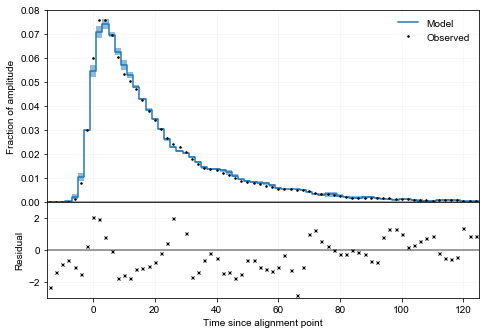

chi2 = 1.476901


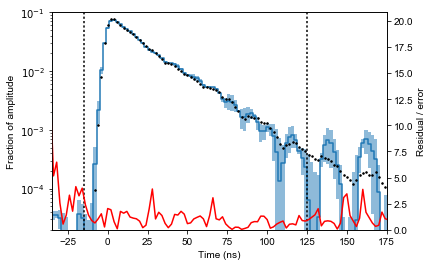

In [237]:
fit = optresult.x
print(fit)
ydata, _ = real_s1_wv(**cust_params)
minus, base, plus = s1_models_error(fs=fit[0], t3=fit[1], tts = fit[2], **cust_params)
comparison_plot(ydata, minus, base, plus, log=False, **cust_params)
# plt.savefig('plots/NR_fit.png', bbox_inches='tight', dpi = 200)
plt.show()
comparison_plot_2(ydata, minus, base, plus, **cust_params)
plt.show()

In [220]:
def get_ratio(fs):
    return fs/(1-fs)

In [221]:
get_ratio(0.19382575)

0.24042661992739162

In [223]:
get_ratio(0.28152421)

0.39183534632391714

### Uncertainty estimate

In [42]:
def gof_v_parameter(parameter, variation_range, num, **params):
    params_to_try = np.linspace(*variation_range, num=num)
    gofs = []
    for param_value in params_to_try:
        params[parameter] = param_value
        gofs.append(gof(**params))
    return params_to_try, np.array(gofs)

from tqdm import tqdm
def gof_v_2_paramters(repeat, parameter1, parameter2, variation_range1, variation_range2, num1, num2, **params):
    import time
    start = time.time()
    params_to_try1 = np.linspace(*variation_range1, num=num1)
    params_to_try2 = np.linspace(*variation_range2, num=num2)
    ding = []
    for par1 in tqdm(params_to_try1):
        for par2 in params_to_try2:
            params[parameter1] = par1
            params[parameter2] = par2
            gof_value = gof_repeat(repeat, **params)
            ding.append([par1, par2, gof_value])
    stop = time.time()
    print('Computation took %d seconds (%.1f s/it)' % ((stop - start), (stop - start) / len(ding)))
    return np.array(ding)

In [172]:
nx = 40
ny = 40
ding = gof_v_2_paramters('fs', 't3', (0.18, 0.20), (24.5, 25.5), nx, ny, tts=fit[2], verbose=False)

100%|██████████| 40/40 [23:29<00:00, 34.72s/it]

Computation took 1409 seconds (0.9 s/it)


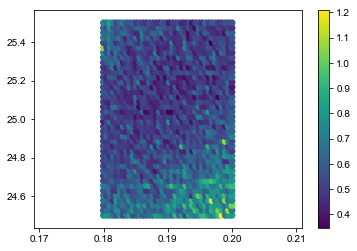

In [173]:
plt.scatter(ding[:,0], ding[:,1], c=ding[:, 2])
plt.colorbar()

In [81]:
chi2 = scipy.stats.chi2

In [101]:
df = int((default_params['t_max'] - default_params['t_min']) * 0.5)

In [125]:
chi2.cdf(3 * 3, df=3)

0.97070911346511179

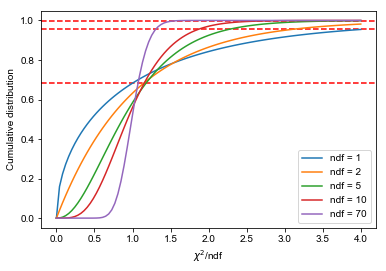

In [144]:
x_plot = np.linspace(0, 4, 100)

for cl in (0.6827, 0.9545, 0.9973):
    plt.axhline(cl, ls='--', color='red')
    
for _df in [1, 2, 5, 10, 70]:
    plt.plot(x_plot, [chi2.cdf(_x * _df, df=_df) for _x in x_plot], label='ndf = %d' % _df)
plt.legend()
plt.xlabel('$\chi^2$/ndf')
plt.ylabel('Cumulative distribution')



In [188]:
x_plot = np.linspace(1, 2, 400)
_df = 70
cl = 0.9545 # 2 sigma


value = x_plot[np.argmin(np.abs(np.array([[chi2.cdf(_x * _df, df=_df) for _x in x_plot]]) - cl))]
print(value)

1.30325814536


In [158]:
chi2.cdf(0.34474512411 * 70, df=70, loc=0, scale=0.34474512411)

0.52248119042994245

In [159]:
chi2.cdf(70, df=70, loc=0, scale=1)

0.52248119042994245

0.346963369167


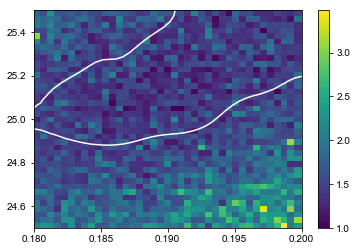

In [187]:
x = np.reshape(ding[:, 0], (nx, ny))
y = np.reshape(ding[:, 1], (nx, ny))
z = np.reshape(ding[:, 2], (nx, ny)) 
print(np.min(z))
z = z / np.min(z)


int_fac = 1
sigma = 3

xn = scipy.ndimage.zoom(x, int_fac)
yn = scipy.ndimage.zoom(y, int_fac)
zn = scipy.ndimage.zoom(z, int_fac)
zn = scipy.ndimage.gaussian_filter(zn, sigma)


levels = [1.5]
plt.contour(xn, yn, zn, levels, colors='white')
plt.pcolormesh(x, y, z)

plt.colorbar()

In [ ]:
edge_x = ding[:, 0]
edge_y = 
plt.figure()
ax = plt.gca()
pc = ax.pcolormesh(edge_x, edge_y, 1000* (h_fg - h_bg).T,  cmap='RdBu', vmin = -3e-1, vmax = 3e-1)

In [157]:
fss, gofs = gof_v_parameter('fs', (0.14, 0.24), 20, fs=fit[0], t3=fit[1], tts=fit[2], error_pct = 1e-2, error_offset = 1e-4)

gof=0.8223248960610716, fs=0.14, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.7518969908565659, fs=0.14526315789473684, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.5375879783198912, fs=0.1505263157894737, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.563174577752749, fs=0.15578947368421053, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.43184031947407575, fs=0.1610526315789474, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.30005747084716083, fs=0.16631578947368422, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.2460460642009813, fs=0.17157894736842105, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.20121751674928934, fs=0.1768421052631579, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.1538217910931106, fs=0.18210526315789474, t1=3.1, t3=25.314533292606356, tts=1.2653254314891729
gof=0.16741921838243617, fs=0.18736842105263157, t1=3.1, t3=25.314533292606356, tts=1.265325431489

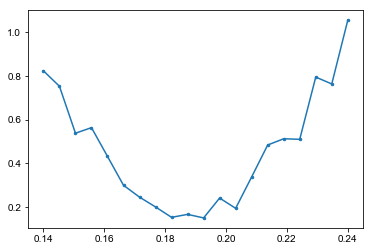

In [158]:
plt.plot(fss, gofs, marker='.', markersize=5)

In [135]:
optresult_nr = optimize.minimize(
    lambda x: gof(fs=x[0], t3=x[1], tts=x[2], dset = 'nr', error_pct = 1e-2, error_offset = 1e-4),
    [0.2, 24, 3],
    bounds=[[.01, 1], [20, 30], [.1, 5]],
    options=dict(maxfev=1000),
    method='Powell',
)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


gof=5.404165191595393, fs=0.2, t1=3.1, t3=24.0, tts=3.0
gof=4.901261384945134, fs=0.2, t1=3.1, t3=24.0, tts=3.0
gof=inf, fs=1.2, t1=3.1, t3=24.0, tts=3.0
gof=inf, fs=-1.418034, t1=3.1, t3=24.0, tts=3.0
gof=5.100265985289571, fs=0.2, t1=3.1, t3=24.0, tts=3.0
gof=inf, fs=-0.418033974844, t1=3.1, t3=24.0, tts=3.0


/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


gof=20.667156369428504, fs=0.581966, t1=3.1, t3=24.0, tts=3.0
gof=inf, fs=-0.036067965235263316, t1=3.1, t3=24.0, tts=3.0
gof=1.5463955247032297, fs=0.34589802515600004, t1=3.1, t3=24.0, tts=3.0
gof=1.6943681213633022, fs=0.31710503490593894, t1=3.1, t3=24.0, tts=3.0
gof=1.9966769477411725, fs=0.34735700541756004, t1=3.1, t3=24.0, tts=3.0
gof=1.5504039444214925, fs=0.3317492787233509, t1=3.1, t3=24.0, tts=3.0
gof=1.5494328170231437, fs=0.3404936850761068, t1=3.1, t3=24.0, tts=3.0
gof=1.665766759993852, fs=0.34383375099304353, t1=3.1, t3=24.0, tts=3.0
gof=1.7171111053948453, fs=0.34589802515600004, t1=3.1, t3=24.0, tts=3.0
gof=2.0321923608937515, fs=0.34589802515600004, t1=3.1, t3=25.0, tts=3.0
gof=1.9879370439724404, fs=0.34589802515600004, t1=3.1, t3=22.381966, tts=3.0
gof=1.6604266196241677, fs=0.34589802515600004, t1=3.1, t3=24.0, tts=3.0
gof=1.7296053834654685, fs=0.34589802515600004, t1=3.1, t3=23.381966025156, tts=3.0
gof=1.7493126792831641, fs=0.34589802515600004, t1=3.1, t3=24.

[  0.28152421  22.90795037   1.47498146]


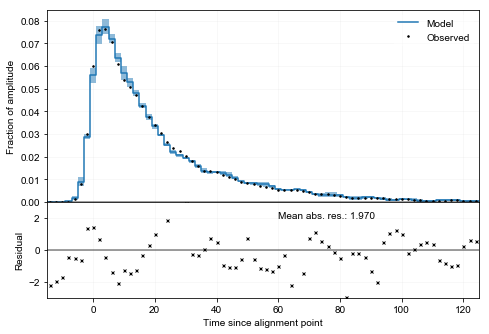

chi2 = 0.700723


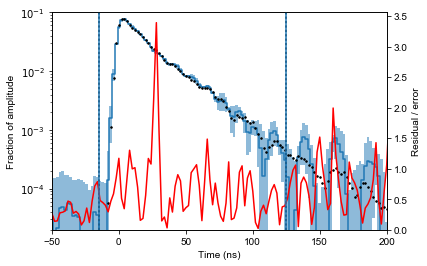

In [137]:
fit = optresult_nr.x
print(fit)
ydata, _ = real_s1_wv(dset='nr')
minus, base, plus = s1_models_error(fs=fit[0], t3=fit[1], tts=fit[2], dset='nr', error_pct = 1e-2, error_offset = 1e-4)
comparison_plot(ydata, minus, base, plus, error_pct = 1e-2, error_offset = 1e-4)
plt.show()
comparison_plot_2(ydata, minus, base, plus, error_pct = 1e-2, error_offset = 1e-4)
for _l in (-15, 125):
    plt.axvline(_l)
plt.xlim(-50, 200)
plt.show()

In [ ]:
plt.hist(xams_data['er']['s1'], bins=100, histtype='step', range=(50,100))
plt.hist(xams_data['nr']['s1'], bins=100, histtype='step', range=(50,100))
plt.show()

## Fit four parameters

### ER

In [4]:
from scipy import optimize
optresult = optimize.minimize(
    lambda x: gof(fs=x[0], t1=x[1], t3=x[2], tts=x[3], s1_min=30, s1_max = 100, dst='er'),
    [0.2, 3.1, 24, 3],
    bounds=[[.01, 1], [.1, 5], [20, 30], [.1, 5]],
    options=dict(maxfev=1000),
    method='Powell',
)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


NameError: name 'gof' is not defined

In [ ]:
# fit = optresult.x
# ydata, _ = real_s1_wv()
# minus, base, plus = s1_models_error(fs=fit[0], t1=fit[1], t3=fit[2], tts=fit[3])
# comparison_plot(ydata, minus, base, plus)

In [ ]:
fit = optresult.x
print(fit)
ydata, _ = real_s1_wv()
minus, base, plus = s1_models_error(fs=fit[0], t1=fit[1], t3=fit[2], tts=fit[3], s1_min=30, s1_max = 100)
comparison_plot(ydata, minus, base, plus)
plt.show()
comparison_plot_2(ydata, minus, base, plus)
for _l in (-20, 100):
    plt.axvline(_l)
plt.xlim(-50, 200)
plt.show()

The fit is pushing the singlet livetime to very low values... There is some degeneracy here, and also some mis-modeling, it seems. The sample at 0 is always under-estimated. Why? Maybe because the tts is actually quite low but modeled here as large. The effects may not be symmetric: there are many things causing a delay, but not a negative delay. 

### NR

In [5]:
from scipy import optimize
optresult = optimize.minimize(
    lambda x: gof(fs=x[0], t1=x[1], t3=x[2], tts=x[3], s1_min=30, s1_max = 100, dst='nr'),
    [0.2, 3.1, 24, 3],
    bounds=[[.01, 1], [.1, 5], [20, 30], [.1, 5]],
    options=dict(maxfev=1000),
    method='Powell',
)

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


NameError: name 'gof' is not defined

In [ ]:
fit = optresult.x
print(fit)
ydata, _ = real_s1_wv()
minus, base, plus = s1_models_error(fs=fit[0], t1=fit[1], t3=fit[2], tts=fit[3], s1_min=30, s1_max = 100, dset='nr')
comparison_plot(ydata, minus, base, plus)
plt.show()
comparison_plot_2(ydata, minus, base, plus)
for _l in (-20, 100):
    plt.axvline(_l)
plt.xlim(-50, 200)
plt.show()